# Calcium Imaging

In this tutorial we'll inject a microscope for two-photon imaging with both the S2F and NAOMi models.

## Preamble

In [ ]:
import brian2.only as b2
from brian2 import np
import cleo
from cleo import imaging
from cleo.ioproc import RecordOnlyProcessor
import matplotlib.pyplot as plt

b2.prefs.codegen.target = "numpy"

# for reproducibility
seed = 18010630
rng = np.random.default_rng(seed)
b2.seed(seed)
cleo.utilities.set_seed(seed)

cleo.utilities.style_plots_for_docs()

## Brian network setup

We will use simple LIF neurons connected to excitatory and inhibitory Poisson inputs.

In [ ]:
N = 500
n_e = int(N * 0.8)
n_i = int(N * 0.2)
n_ext = N

neurons = b2.NeuronGroup(
    N,
    "dv/dt = -v / (10*ms) : 1",
    threshold="v > 1",
    reset="v = 0",
    refractory=2 * b2.ms,
    method="exact",
    name="neurons"
)
ext_input = b2.PoissonGroup(n_ext, 24 * b2.Hz, name="ext_input")
cleo.coords.assign_coords_rand_rect_prism(
    neurons, xlim=(-0.2, 0.2), ylim=(-0.2, 0.2), zlim=(0, 0.4)
)
# need to create subgroups after assigning coordinates
exc = neurons[:n_e]
inh = neurons[n_e:]

w0 = 0.06
syn_exc = b2.Synapses(
    exc,
    neurons,
    f"w = {w0} : 1",
    on_pre="v_post += w",
    name="syn_exc",
    delay=1.5 * b2.ms,
)
syn_exc.connect(p=0.1)
syn_inh = b2.Synapses(
    inh,
    neurons,
    f"w = -4*{w0} : 1",
    on_pre="v_post += w",
    name="syn_inh",
    delay=1.5 * b2.ms,
)
syn_inh.connect(p=0.1)
syn_ext = b2.Synapses(
    ext_input, neurons, "w = .05 : 1", on_pre="v_post += w", name="syn_ext"
)
syn_ext.connect(p=0.1)

net = b2.Network([neurons, exc, inh, syn_exc, syn_inh, ext_input, syn_ext])
sim = cleo.CLSimulator(net)

## Microscope configuration

We will create scopes for both NAOMi and S2F sensors. Note that S2F sensors will not use `focus_depth` to select target neurons like NAOMi sensors do.

WARNING    /home/raahi/Projects/SIPLab/cleo/cleo/imaging/scope.py:299: UserWarning: SNR cutoff not used, since GCaMP6f_S2F does not have dFF_1AP defined.
  warnings.warn(
 [py.warnings]
WARNING    /home/raahi/Projects/SIPLab/cleo/cleo/imaging/scope.py:299: UserWarning: SNR cutoff not used, since GCaMP6s_S2F does not have dFF_1AP defined.
  warnings.warn(
 [py.warnings]


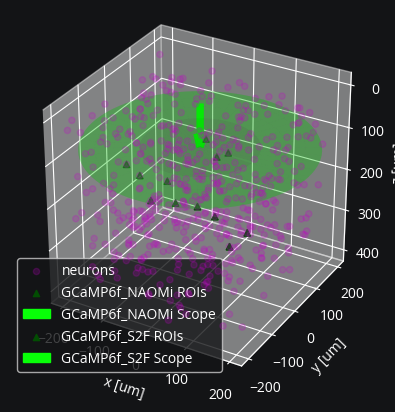

In [ ]:
expr_level_gen = lambda n: rng.lognormal(0, 0.2, n)

naomi_sensors = [imaging.gcamp6f_naomi(), imaging.gcamp6s_naomi()]
s2f_sensors = [imaging.gcamp6f_s2f(), imaging.gcamp6s_s2f()]

naomi_scopes = {}
for naomi_sensor in naomi_sensors:
    naomi_scopes[naomi_sensor] = imaging.Scope(
        focus_depth=100 * b2.um,
        img_width=500 * b2.um,
        sensor=naomi_sensor,
        name=f"{naomi_sensor.name} Scope"
    )
    sim.inject(
        naomi_scopes[naomi_sensor],
        neurons,
        focus_depth=200 * b2.um,
        soma_radius=5 * b2.um,
        rho_rel_generator=expr_level_gen
    )

s2f_scopes = {}
for s2f_sensor in s2f_sensors:
    s2f_scopes[s2f_sensor] = imaging.Scope(
        focus_depth=100 * b2.um,
        img_width=500 * b2.um,
        sensor=s2f_sensor,
        name=f"{s2f_sensor.name} Scope"
    )
    sim.inject(
        s2f_scopes[s2f_sensor],
        neurons,
        focus_depth=200 * b2.um,
        soma_radius=5 * b2.um,
        rho_rel_generator=expr_level_gen
    )

# Only display first s2f and naomi sensors
cleo.viz.plot(neurons, colors=["#c500cc"], sim=sim, devices=[naomi_scopes[naomi_sensors[0]], s2f_scopes[s2f_sensors[0]]]);

Once the targets have been selected, we can inject the sensors for each scope. This process is the same regardless of whether the sensor is NAOMi or S2F.

In [ ]:
for naomi_sensor in naomi_scopes:
    naomi_scopes[naomi_sensor].inject_sensor_for_targets()
for s2f_sensor in s2f_scopes:
    s2f_scopes[s2f_sensor].inject_sensor_for_targets()

## Running Simulation

In this case, we only want to record the calcium traces, not stimulate, so we will use a {class}`~cleo.ioproc.RecordOnlyProcessor`.

In [ ]:
sim.set_io_processor(RecordOnlyProcessor(sample_period=1 * b2.ms))

sim.reset()
sim.run(1 * b2.second)

INFO       No numerical integration method specified for group 'syn_GCaMP6f_NAOMi_neurons', using method 'euler' (took 0.02s, trying other methods took 0.06s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_GCaMP6s_NAOMi_neurons', using method 'euler' (took 0.01s, trying other methods took 0.01s). [brian2.stateupdaters.base.method_choice]
WARNING    /home/raahi/.cache/pypoetry/virtualenvs/cleosim-Rr38eAtN-py3.12/lib/python3.12/site-packages/brian2/units/fundamentalunits.py:1185: RuntimeWarning: divide by zero encountered in divide
  uf_method(*[np.asarray(a) for a in inputs], **kwargs), dim=dim
 [py.warnings]


Finally, we may visualize the results and compare the two models.

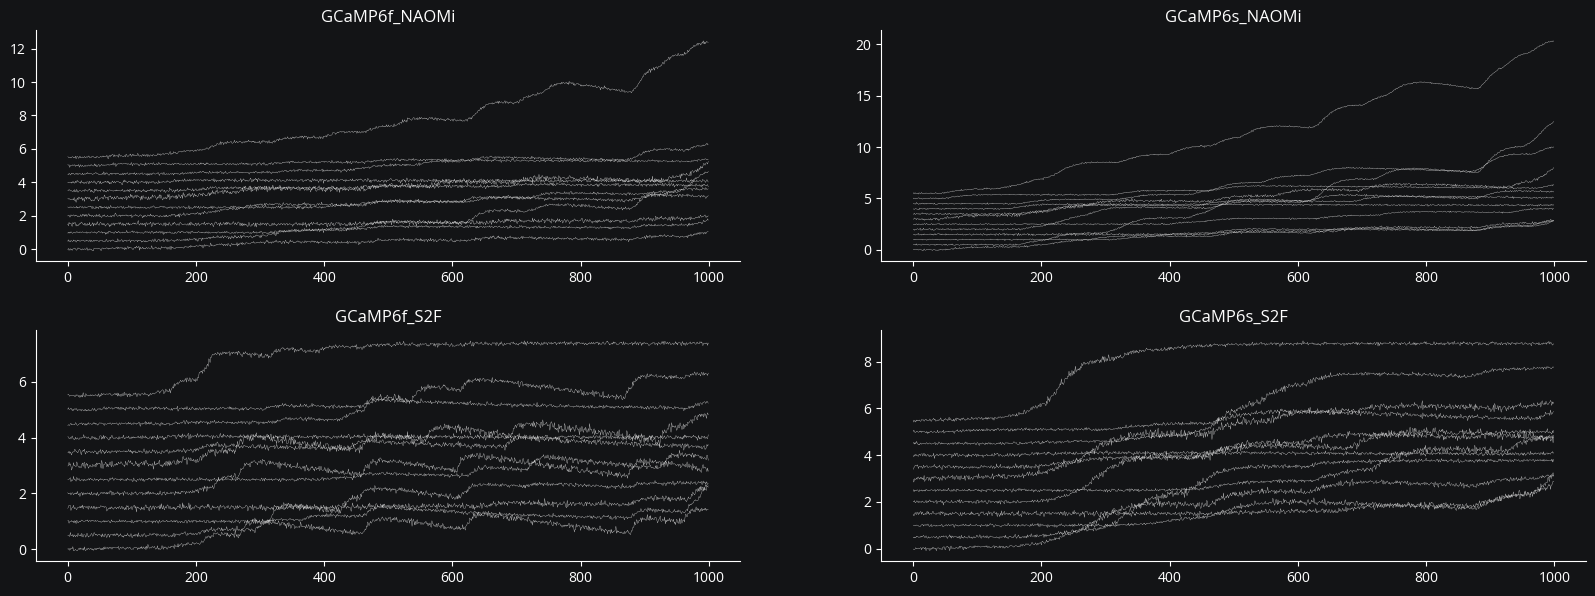

In [ ]:
fig = plt.figure(figsize=(20, 6))
naomi_fig, s2f_fig = fig.subfigures(2, 1)
naomi_axes = naomi_fig.subplots(1, len(naomi_sensors))
s2f_axes = s2f_fig.subplots(1, len(s2f_sensors))

sep = 0.5
for i, (naomi_sensor, naomi_scope) in enumerate(naomi_scopes.items()):
    fluorescence = np.array(naomi_scope.dFF)
    naomi_axes[i].plot(naomi_scope.t / b2.ms, fluorescence + sep * np.arange(fluorescence.shape[1]), lw=0.2, c="w", rasterized=True)
    naomi_axes[i].set_title(f"{naomi_sensor.name}")

for i, (s2f_sensor, s2f_scope) in enumerate(s2f_scopes.items()):
    fluorescence = np.array(s2f_scope.dFF)
    s2f_axes[i].plot(s2f_scope.t / b2.ms, fluorescence + sep * np.arange(fluorescence.shape[1]), lw=0.2, c="w", rasterized=True)
    s2f_axes[i].set_title(f"{s2f_sensor.name}")